See wiki page: https://wiki.cosmos.esa.int/planckpla2015/index.php/Main_Page

Links for masks:
http://irsa.ipac.caltech.edu/data/Planck/release_2/ancillary-data/previews/HFI_Mask_PointSrc_2048_R2.00/header.txt
http://irsa.ipac.caltech.edu/data/Planck/release_2/ancillary-data/previews/HFI_Mask_GalPlane-apo5_2048_R2.00/header.txt

SZ Source Catalog: 
https://wiki.cosmos.esa.int/planckpla2015/index.php/Catalogues#.282015.29_Second_SZ_Catalogue

Format: Healpix format, with Nside of 1024 (LFI 30, 44 and 70) and 2048 (LFI 70 and HFI), in Galactic coordinates, and Nested ordering. 

# Reading a polarization map at 100 GHz

In [1]:
path = "/Users/inchani/Desktop/UC\ Davis/My\ Courses/STA\ 250\ (AstroStatistics)/Project/"; 
include("$path""lib.jl")
map_name = "HFI_SkyMap_100_2048_R2.02_full.fits"; # Polarization map at 100 GHz
using PyCall, PyPlot
@pyimport healpy as hp
@pyimport healpy.fitsfunc as fitsfunc;
@pyimport healpy.pixelfunc as pixelfunc;
@pyimport numpy as np;

dθ = dϕ = 0.0007669903939429012;  # 5 arcmin of resolution to radian
NSIDE = 2048;
Nested = false;
I_STOKES = hp.read_map("$path$map_name", field = 0, memmap = true);
dim = length(I_STOKES);

const dtheta_deg = 15.
const dtheta = dtheta_deg / 180 * pi;   # 15 degrees in radian
const FWHM    = 30. / 60. * pi / 180;   # 30. arcmin to radian unit (See Planck 2013 ISW paper)
const σ       = FWHM / 2.355            # 2.355 ~ 2√(2log(2))
const σnorm2  = 2.*σ^2.
const σlim2   = (3σ)^2.  

const angsize    = copy(dtheta_deg*2)             # width and height in degree 
const XYsize     = angsize * pi / 180;            # in radian 
const res        = 6. / 60. * pi / 180;  
        # 6 arcmin of pixel size in radian unit (See Planck 2013 ISW paper)
const Nsize      = Int64(round(XYsize/res));      # 300

const Tmin = -593.5015506111085; # mu K  
const Tmax =  709.0113358572125; # mu K 
# min and max temperature if we take out 40 % of sky as foreground

NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


/Users/inchani/.local/lib/python2.7/site-packages/healpy/fitsfunc.py:335: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  "assume {}".format(schm))


709.0113358572125

In [ ]:
Q_STOKES = hp.read_map("$path$map_name", field = 1, memmap = true);
U_STOKES = hp.read_map("$path$map_name", field = 2, memmap = true);

Each fits file contains:

Field 0  = I_STOKES, the intensity in each specific band 
Field 1  = Q_STOKES, the polarized brightness 
Field 2  = U_STOKES,        
Field 3  = HITS    , the number of observations 
Field 4  = II_COV  , the variance in the corresponding Stokes parameter 
Field 5  = IQ_COV          
Field 6  = IU_COV  , the covariance inbetween the corresponding Stokes parameter  
Field 7  = QQ_COV  
Field 8  = QU_COV  
Field 9  = UU_COV 

# Reading mask maps

In [2]:
GalMapFile = "HFI_Mask_GalPlane-apo5_2048_R2.00.fits"
PtMapFile  = "HFI_Mask_PointSrc_2048_R2.00.fits"
GalMap     = hp.read_map("$path$GalMapFile", field = 2, memmap = true); # 40% of sky is ruled out
PtMap      = hp.read_map("$path$PtMapFile", field = 0, memmap = true);  

NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


(Ordering converted to RING)

# Intensity of all-sky map before masking

/Users/inchani/python/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


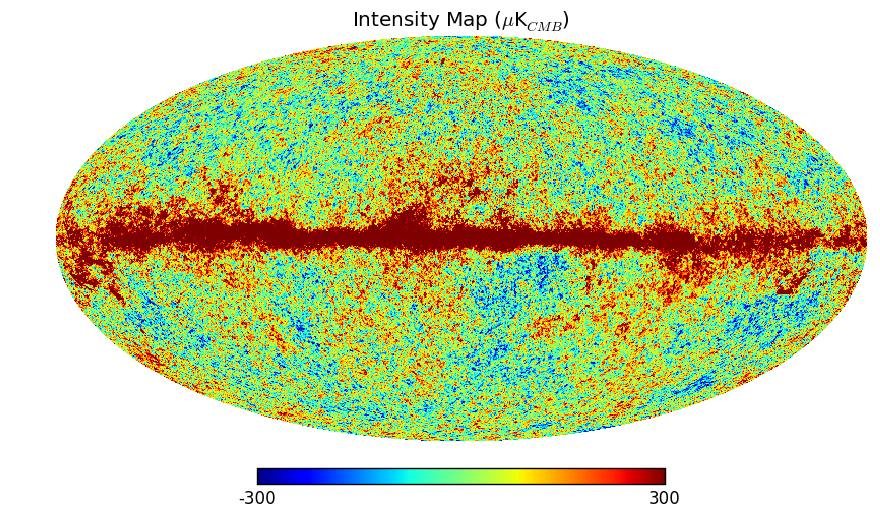

In [3]:
hp.mollview(I_STOKES*1e6, xsize = 800, title = "Intensity Map (\$\\mu\$\K\$\_{CMB}\$\)", min = -300, max = 300)
savefig("$path/allskymap.png")

masking galactic foregrounds and point sources

In [3]:
planck_map_mask = copy(I_STOKES)*1e6
cnt = 0
for i = 1:max(length(GalMap),length(PtMap))
    if (GalMap[i] == 0.) | (PtMap[i] == 0.)
        planck_map_mask[i] = hp.UNSEEN
        cnt += 1
    end
end

# Intensity of all-sky map after masking galactic foregrounds and point sources

/Users/inchani/python/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


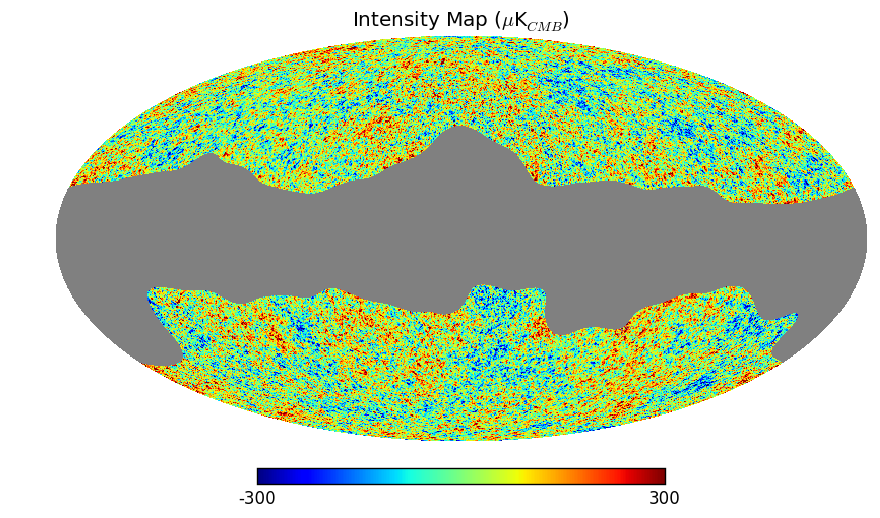

In [4]:
hp.mollview(planck_map_mask, xsize = 800, title = "Intensity Map (\$\\mu\$\K\$\_{CMB}\$\)", min = -300, max = 300)
savefig("$path/allskymap_mask.png")

# Loading supercluster / void sources

How to use pixelfunc for change index to coord, or vice versa.
@pyimport healpy.pixelfunc as pixelfunc
ind = 0
l,b     = pixelfunc.pix2ang(2048,ind,nest=false)   # pixel index > Spherical Coord, [θ, ϕ] [radian unit]
ind_rtn = pixelfunc.ang2pix(2048,l,b,nest=false)   # Spherical Coord, [θ, ϕ]> pixel index
Note: ϕ = 0 (θ=90 deg) is toward galactic center > need to convert coordinates of SZ sources
      increasing ϕ = moving East, increasing θ = moving South

In [5]:
CoordSZ       = np.load("$path""Coord_SZ.npy");
CoordGR08SC   = np.load("$path""Coord_GR08_sc.npy");
CoordGR08Void = np.load("$path""Coord_GR08_void.npy");

In [6]:
Coord_obj = copy(CoordSZ);

Nsample = 10;

planck_map = copy(I_STOKES)*1e6;
i_pixel    = Array(Int64, 0)     # a list of pixel indices of a supercluster 
ids        = Array(Int64, 0)     # survived index of Coord_obj after sorting out bad samples
N_obj      = Array(Int64, 0)     # number of pixels in a region

println("---| Start clipping regions of superclusters: 30 deg x 30 deg (15 deg = $dtheta radian)")

i = 0; ntry = 1;

if Nsample > length(Coord_obj[:,1])
    Nsample = length(Coord_obj[:,1])
end
while (i < Nsample) & (ntry < length(Coord_obj))
    l, b = Coord_obj[ntry,:]
    θ = l * 180 / pi
    ϕ = b * 180 / pi
    #if (( θ > 15. ) & (θ < 75.)) | (( θ > 115. ) & (θ < 165.))
    N, ind = SpheCoord2Index(Coord_obj[ntry,1]-dtheta,Coord_obj[ntry,1]+dtheta,
    Coord_obj[ntry,2]-dtheta,Coord_obj[ntry,2]+dtheta;discrepancy=0.7)   
    if N > 0 
        i +=1        
        println("   |>> No. $i out of $ntry with angular position, (θ,ϕ) = ($θ, $ϕ)")            
        planck_map[ind] = hp.UNSEEN
        ids             = vcat(ids, i)
        N_obj           = vcat(N_obj, N)
        i_pixel         = vcat(i_pixel, ind)
        println("   |>> total N = $N")
    end
    #end
    ntry +=1
end


---| Start clipping regions of superclusters: 30 deg x 30 deg (15 deg = 0.2617993877991494 radian)
   |> dϕ = 0.0008260573356855261,  Nϕ = 633.8528247119501
   |> finding pixels in the region...
   |> Scheme No.2 & returning (684+1=685, 1350) array
   |>> No. 1 out of 1 with angular position, (θ,ϕ) = (57.097190518679, 286.98880321352937)
   |>> total N = 924750
   |> dϕ = 0.0007297101876213574,  Nϕ = 717.5434638031827
   |> finding pixels in the region...
   |> Scheme No.3 & returning (683, 1294) array
   |>> No. 2 out of 2 with angular position, (θ,ϕ) = (129.462116915104, 205.93719459223158)
   |>> total N = 883802
   |> dϕ = 0.000742244550913318,  Nϕ = 705.4262304169431
   |> finding pixels in the region...
   |> Found a huge discrepancy btwn Nϕpix(6271) and Nϕ... exit
   |> dϕ = 0.0006414030005430504,  Nϕ = 816.3335300193309
   |> finding pixels in the region...
   |> Scheme No.2 & returning (684+1=685, 1486) array
   |>> No. 3 out of 4 with angular position, (θ,ϕ) = (68.96845669141

# Some of the clipped spuerclusters (SZ source) on the CMB map

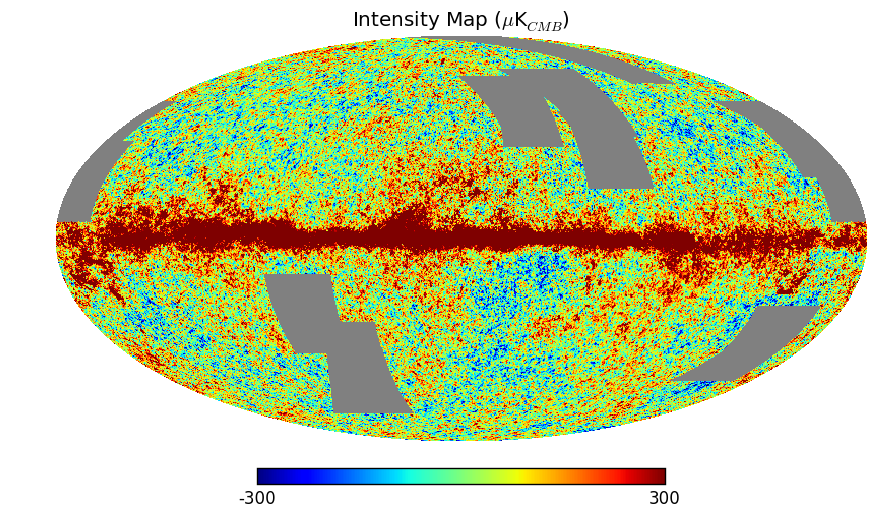

In [7]:
hp.mollview(planck_map, xsize = 800, title = "Intensity Map (\$\\mu\$\K\$\_{CMB}\$\)", min = -300, max = 300)

In [8]:
Coord_obj = copy(CoordGR08SC);

Nsample = 20;

planck_map = copy(I_STOKES)*1e6;
i_pixel    = Array(Int64, 0)     # a list of pixel indices of a supercluster 
ids        = Array(Int64, 0)     # survived index of Coord_obj after sorting out bad samples
N_obj      = Array(Int64, 0)     # number of pixels in a region

println("---| Start clipping regions of superclusters: 30 deg x 30 deg (15 deg = $dtheta radian)")

i = 0; ntry = 1;

if Nsample > length(Coord_obj[:,1])
    Nsample = length(Coord_obj[:,1])
end
while (i < Nsample) & (ntry < length(Coord_obj))
    l, b = Coord_obj[ntry,:]
    θ = l * 180 / pi
    ϕ = b * 180 / pi
    #if (( θ > 15. ) & (θ < 75.)) | (( θ > 115. ) & (θ < 165.))
    N, ind = SpheCoord2Index(Coord_obj[ntry,1]-dtheta,Coord_obj[ntry,1]+dtheta,
    Coord_obj[ntry,2]-dtheta,Coord_obj[ntry,2]+dtheta;discrepancy=0.7)   
    if N > 0 
        i +=1        
        println("   |>> No. $i out of $ntry with angular position, (θ,ϕ) = ($θ, $ϕ)")            
        planck_map[ind] = hp.UNSEEN
        ids             = vcat(ids, i)
        N_obj           = vcat(N_obj, N)
        i_pixel         = vcat(i_pixel, ind)
        println("   |>> total N = $N")
    end
    #end
    ntry +=1
end

---| Start clipping regions of superclusters: 30 deg x 30 deg (15 deg = 0.2617993877991494 radian)
   |> dϕ = 0.0005161676571288076,  Nϕ = 1014.3967146466077
   |> finding pixels in the region...
   |> Scheme No.3 & returning (682, 1358) array
   |>> No. 1 out of 1 with angular position, (θ,ϕ) = (57.863911202212805, 181.53780858422533)
   |>> total N = 926156
   |> dϕ = 0.0005523651148240383,  Nϕ = 947.921513408929
   |> finding pixels in the region...
   |> Found a huge discrepancy btwn Nϕpix(5861) and Nϕ... exit
   |> dϕ = 0.0009522604409775148,  Nϕ = 549.8482905168404
   |> finding pixels in the region...
   |> Found a huge discrepancy btwn Nϕpix(4023) and Nϕ... exit
   |> θmin is smaller than 1° ... set θmin = 1°
   |> dϕ = 0.002165895883733171,  Nϕ = 241.74697386460534
   |> finding pixels in the region...
   |> Scheme No.2 & returning (302+1=303, 858) array
   |>> No. 2 out of 4 with angular position, (θ,ϕ) = (5.700184797799451, 141.95137500511055)
   |>> total N = 259974
   |> d

# Some of the clipped spuerclusters (GR08) on the CMB map

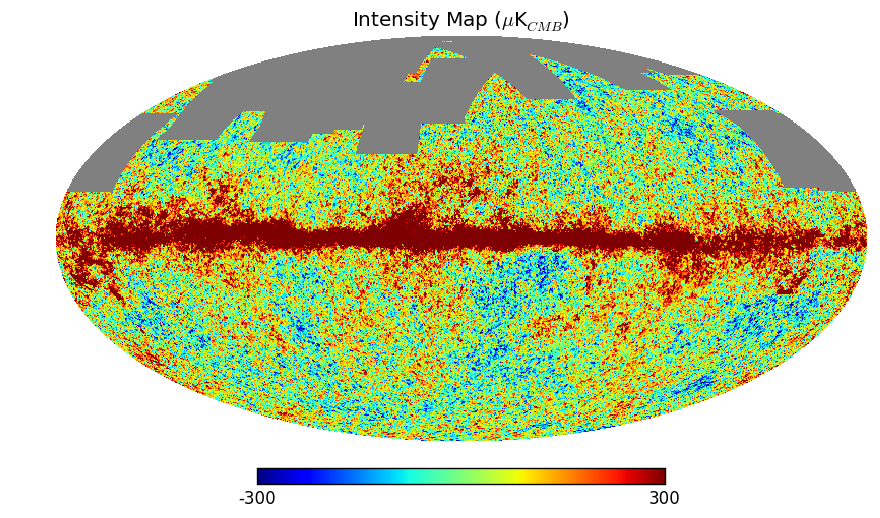

In [9]:
hp.mollview(planck_map, xsize = 800, title = "Intensity Map (\$\\mu\$\K\$\_{CMB}\$\)", min = -300, max = 300)

# Generate random sample (θ,ϕ) outside the foreground

In [13]:
Nrs = 50;
Ntry = 1; i = 0;
CoordRand  = Array(Float64, Nrs, 2)
N_rs       = Array(Int64, 0)
i_rs_pixel = Array(Int64, 0)
println("constructing random coordinates")
while i < Nrs
    θ = (rand() * 178 + 1.) * pi / 180.
    ϕ = rand() * 2pi
    #if (θ < 60.) | (θ > 120.)       # choose θ where  1 < θ < 75 or 105 < θ < 179 degree
    if planck_map_mask[pixelfunc.ang2pix(2048,θ,ϕ)] > hp.UNSEEN
        N, ind = SpheCoord2Index(θ-dtheta,θ+dtheta,ϕ-dtheta,ϕ+dtheta)   
        if N > 0
            i +=1        
            println("No. $i out of $Ntry tries with angular position, (θ,ϕ) = (", θ*180/pi, ", ", ϕ*180/pi,")")            
            N_rs            = vcat(N_rs, N)
            i_rs_pixel      = vcat(i_rs_pixel, ind)
            CoordRand[i,:]  = [θ, ϕ]
        end
    end
    Ntry += 1
end
np.save("$path""CoordRand""$Nrs",CoordRand)

constructing random coordinates
   |> dϕ = 0.000995593127252281,  Nϕ = 525.9164223475198
   |> finding pixels in the region...
   |> Scheme No.3 & returning (540, 1284) array
No. 1 out of 1 tries with angular position, (θ,ϕ) = (22.682542995226918, 53.69295671569621)
   |> dϕ = 0.000502148109150724,  Nϕ = 1042.717807867193
   |> finding pixels in the region...
   |> Found a huge discrepancy btwn Nϕpix(4596) and Nϕ... exit
   |> dϕ = 0.0009504560367346038,  Nϕ = 550.8921563559953
   |> finding pixels in the region...
   |> Scheme No.2 & returning (684+1=685, 1252) array
No. 2 out of 3 tries with angular position, (θ,ϕ) = (34.474515701004115, 123.79075772423235)
   |> dϕ = 6.281163893070641,  Nϕ = 0.08336015179860705
   |> Poor resolution... exit
   |> θmin is smaller than 1° ... set θmin = 1°
   |> dϕ = 0.0018200535021106745,  Nϕ = 287.6831779895991
   |> finding pixels in the region...
   |> Scheme No.2 & returning (401+1=402, 1156) array
No. 3 out of 6 tries with angular position, (θ,ϕ

In [11]:
CoordRand = np.load("$path""CoordRand10.npy");
planck_map = copy(I_STOKES)*1e6
for i = 1:length(CoordRand[:,1])
    l, b = CoordRand[i,:]
    N, ind = SpheCoord2Index(CoordRand[i,1]-dtheta,CoordRand[i,1]+dtheta,
    CoordRand[i,2]-dtheta,CoordRand[i,2]+dtheta) 
    planck_map[ind] = hp.UNSEEN
end

   |> dϕ = 0.0007486150668025715,  Nϕ = 699.4232400833912
   |> finding pixels in the region...
   |> Scheme No.2 & returning (684+1=685, 1248) array
   |> dϕ = 0.00087044231136435,  Nϕ = 601.5318519817796
   |> finding pixels in the region...
   |> Scheme No.2 & returning (394+2=396, 1362) array
   |> dϕ = 0.0006420673031186652,  Nϕ = 815.4889262466133
   |> finding pixels in the region...
   |> Scheme No.2 & returning (684+1=685, 1256) array
   |> dϕ = 0.0007804321346993603,  Nϕ = 670.9087854256541
   |> finding pixels in the region...
   |> Scheme No.3 & returning (683, 1448) array
   |> θmax is greater than 179° ... set θmax = 179°
   |> dϕ = 0.0017450046706217748,  Nϕ = 300.05580180580927
   |> finding pixels in the region...
   |> Scheme No.3 & returning (240, 678) array
   |> dϕ = 0.0009427759429527782,  Nϕ = 555.3798646562677
   |> finding pixels in the region...
   |> Scheme No.3 & returning (683, 1248) array
   |> dϕ = 0.0011964882764639029,  Nϕ = 437.6129594397206
   |> find

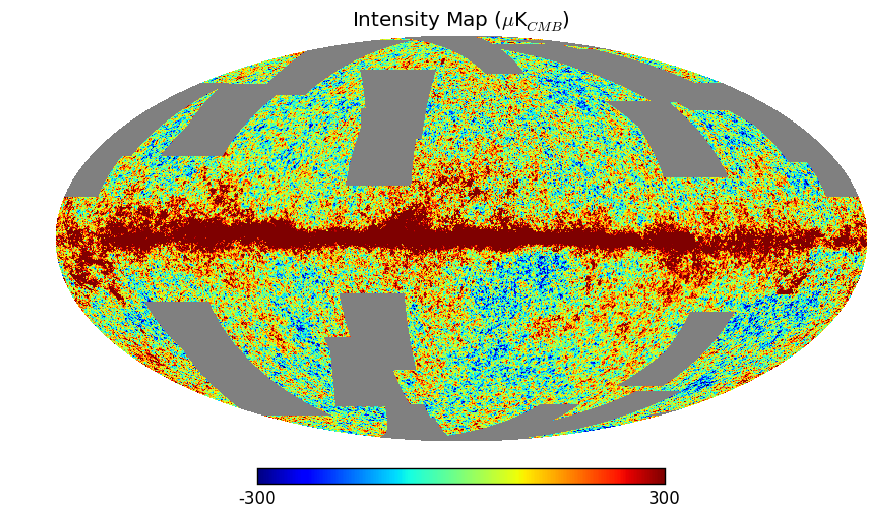

In [14]:
hp.mollview(planck_map, xsize = 800, title = "Intensity Map (\$\\mu\$\K\$\_{CMB}\$\)", min = -300, max = 300)

In [16]:
function GKernel(x::Float64,y::Float64,x₀::Float64,y₀::Float64)
    r2 = (x-x₀)^2. + (y-y₀)^2.
    if r2 < σlim2
        return exp( -r2 / σnorm2 )
    else
        return 0.
    end
end

GKernel (generic function with 1 method)

In [29]:
x1d      = linspace(-XYsize*0.5,XYsize*0.5,Nsize)
y1d      = linspace(XYsize*0.5,-XYsize*0.5,Nsize)
Tmap     = Float64[ GKernel(xi,yi,0.,0.) for xi in x1d, yi in y1d];
Umap     = Float64[ GKernel(xi,yi,0.,0.)>0.? 1.:0. for xi in x1d, yi in y1d];
TmapNorm =  sum(Tmap);
Tmap    /= TmapNorm;

# Gaussian Kernel (2-dim) with FHWM of 30 arcmin at 100 GHz

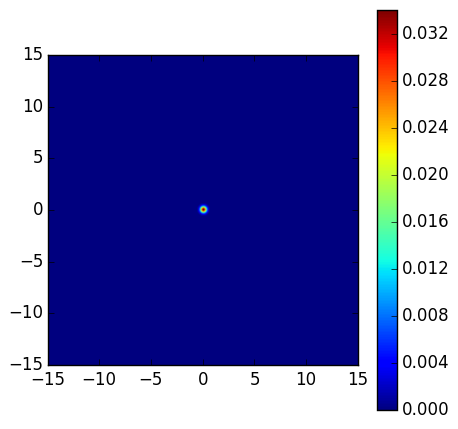

In [31]:
figure(figsize=(5,5))
imshow(Tmap, origin='l', extent= [-dtheta_deg,dtheta_deg,-dtheta_deg,dtheta_deg])
colorbar();

Testing if the superposition of unit kernel works well.

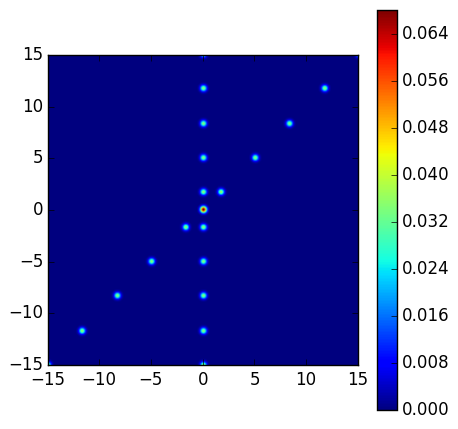

In [23]:
#x   = rand(30) * XYsize - 0.5XYsize
#y   = rand(30) * XYsize - 0.5XYsize
x   = [linspace(-XYsize/2,XYsize/2, 10); linspace(-XYsize/2,XYsize/2, 10);zeros(2)]
y   = [linspace(-XYsize/2,XYsize/2, 10); zeros(10);zeros(2)]
θc, ϕc = 0., 0.;
TestMap = zeros(Nsize,Nsize)
for i =1:length(x)
    θ, ϕ = x[i], y[i]
    row_shift = Int64(round( (θ - θc) /res )) 
    col_shift = Int64(round( (ϕ - ϕc) /res ))
    TestMap += ShiftArray(Tmap, row_shift, col_shift)
end
figure(figsize=(5,5))
imshow(TestMap, origin='l', extent= [-dtheta_deg,dtheta_deg,-dtheta_deg,dtheta_deg])
colorbar();

# Masking Foregounds + Point Sources

In [17]:
planck_map = copy(I_STOKES) * 1e6 # Converting it to mu K scale;
Tmin = -593.5015506111085 # mu K
Tmax = 137299.59726333618 # mu K

for i = 1:max(length(GalMap),length(PtMap))
    if (GalMap[i] == 0.) | (PtMap[i] == 0.)
        planck_map[i] = hp.UNSEEN
    end
end


# (I have stacked Temp. map of super clusters in aother computer)

In [ ]:
@time StackImage = StackImg(1,49;degrade=0);
np.save("$path""stackedimg",StackImage)

# 20 Stacked (averaged) SZ sources (μK)

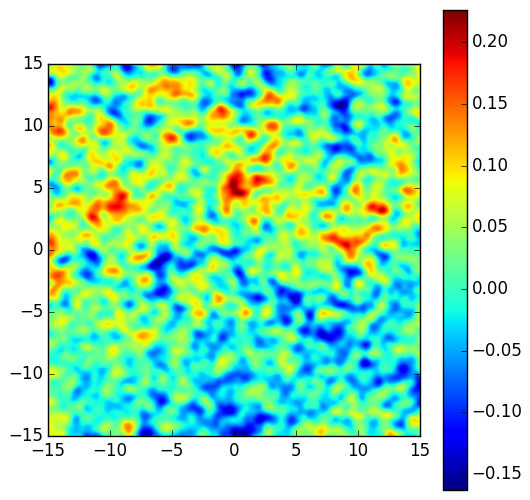

In [45]:
img = np.load("$path""stacked20img_Coord_SZ.npy");
vmin = np.min(img); vmax = np.max(img)
figure(figsize=(6,6))
imshow(img, origin='l',vmin = vmin, vmax = vmax, extent= [-15,15,-15,15])
colorbar();